In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/StableManipulation/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq
using Plots
using Convex, SCS
using JLD
using StableManipulation

In [3]:
include("../models/rod_corner_frictionless_concave.jl")

Main.RodWorld

In [4]:
dynamics! = RodWorld.ode_dynamics!
conditions = RodWorld.ode_conditions
affect! = RodWorld.ode_affect!
affect_neg! = RodWorld.ode_affect_neg!

ode_affect_neg! (generic function with 1 method)

In [29]:
# goal: hold the rod at 45 degrees at the corner
xref = [cos(pi/4)*RodWorld.l/2; sin(pi/4)*RodWorld.l/2; pi/4; 0; 0; 0]

nominal_mode = [true, true]

function wrench_control_2_body(x, control_u)
    u = [control_u[1]; control_u[2]; 
        control_u[3] - control_u[1]*sin(x[3])*RodWorld.l/2 + control_u[2]*cos(x[3])*RodWorld.l/2]
    return u
end

function control_discrete_dynamics(x, control_u, mode)
    u = wrench_control_2_body(x,control_u)
    xn = RodWorld.discrete_dynamics(x, u, mode)
    return xn
end

function control_dynamic(x, control_u, mode)
    u = wrench_control_2_body(x,control_u)
    dx = RodWorld.continuous_dynamics_differentiable(x, u, mode)
    return dx
end

control_u_ref = [-RodWorld.m*RodWorld.g*cot(pi/4)/2; 0; 0]

3-element Vector{Float64}:
 -4.900000000000001
  0.0
  0.0

In [5]:
function no_controller(x, contactMode)
    return zeros(3)
end

no_controller (generic function with 1 method)

In [30]:
function ref_controller(x, contactMode)
    f = wrench_control_2_body(x, control_u_ref)
    # f = [0;RodWorld.m*RodWorld.g;0]
    return f
end

ref_controller (generic function with 1 method)

In [41]:
# LQR controller
# compute infinite horizon K
A_lqr = ForwardDiff.jacobian(_x->control_discrete_dynamics(_x, control_u_ref, nominal_mode), xref)
B_lqr = ForwardDiff.jacobian(_u->control_discrete_dynamics(xref, _u, nominal_mode), control_u_ref)
# Q_lqr = Diagonal([1.0; 1.0; 1.0; 0.5; 0.5; 0.5])
Q_lqr = Diagonal([1.0; 1.0; 1.0; 1.0; 1.0; 1.0])
R_lqr = Diagonal([0.1; 0.1; 0.1])

Ks, _ = StableManipulation.riccati(A_lqr,B_lqr,Q_lqr,R_lqr,Q_lqr,50)
K_lqr = Ks[1]

function lqr_controller(x, contactMode)
    control_u = control_u_ref .- K_lqr*(x .- xref)
    f = wrench_control_2_body(x,control_u)
    return f
end


lqr_controller (generic function with 1 method)

In [53]:
# goal: hold the rod at 45 degrees at the corner

controller = lqr_controller

x0 = xref .+ [-0.1;0;0.01;0;0;0]
initial_mode = [false, true]

tspan = (0.0, 3.0)
callback_length = 2*RodWorld.n_contacts

h_control = RodWorld.Δt

prob = ODEProblem(dynamics!, x0, tspan, (initial_mode, controller, [0.0], h_control, controller(x0, initial_mode)))
cb = VectorContinuousCallback(conditions, affect!, affect_neg!, callback_length)
sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15, adaptive=false,dt=RodWorld.Δt)
println("Simulation status: ", sol.retcode)

New mode from IV: Bool[1, 0]
[-0.339242572669172, -0.7554119749346624, 3.966690424006045, 0.6939625456444507, -3.0382972097324816, 1.8893253622639397]
Simulation status: Success


┌ Info: Saved animation to 
│   fn = /home/xianyi/.julia/dev/StableManipulation/example/anim.gif
└ @ Plots /home/xianyi/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/xianyi/.julia/dev/StableManipulation/example/anim.gif")
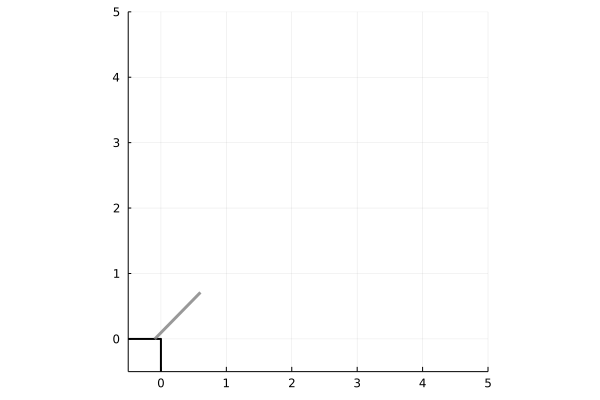

In [54]:
n = length(sol.t)
# n = Int(floor(0.77/Δt))
x = zeros(n)
y = zeros(n)
θ = zeros(n)
for k = 1:n
    x[k] = sol.u[k][1]
    y[k] = sol.u[k][2]
    θ[k] = sol.u[k][3]
end

RodWorld.animation(x,y,θ,n)